In [18]:
#Imports
from os import listdir
import random
from tkinter import E
from xmlrpc.client import boolean
from numpy.core.records import array
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.nn.modules import loss
import eikon as ek
import math
from threading import Event
from datetime import datetime, date
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

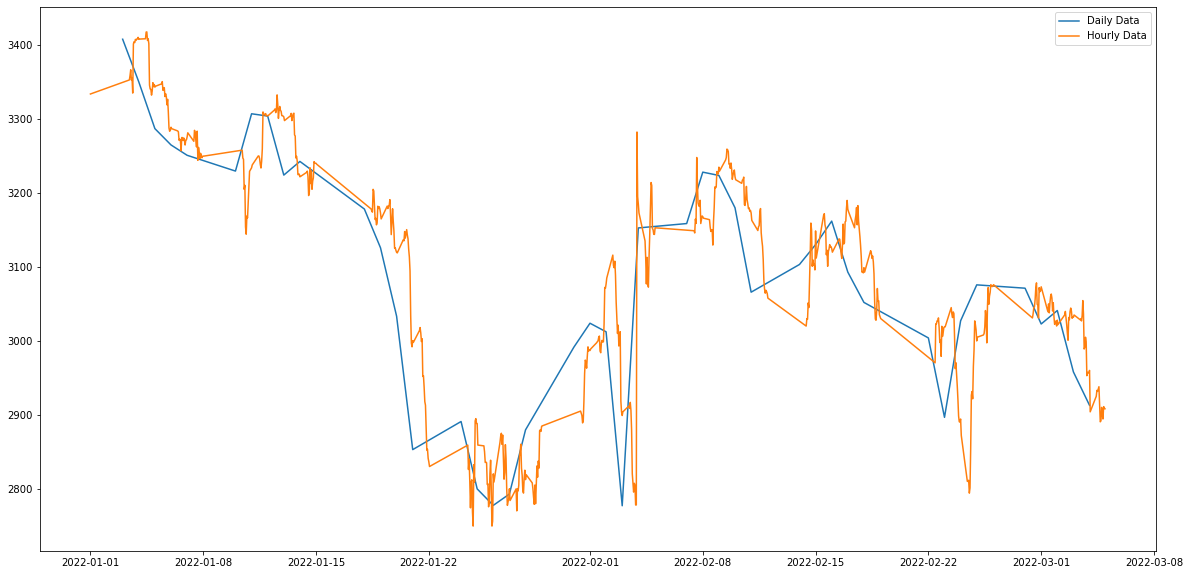

In [19]:
#Shape and transform data
data_daily = pd.read_csv(r"C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\JugendForscht\CSVs\data_daily.csv", index_col="Date", parse_dates=True)
data_hourly = pd.read_csv(r"C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\JugendForscht\CSVs\data_hourly.csv", index_col="Date", parse_dates=True)
#print(len(data_daily))
#print(len(data_hourly))

def plotRawData():
    plt.figure(figsize=(20,10))
    plt.plot(data_daily["CLOSE"], label="Daily Data")
    plt.plot(data_hourly["CLOSE"], label="Hourly Data")
    plt.legend()
    plt.show()
plotRawData()

In [20]:
mm_hourly = MinMaxScaler(feature_range=(0,1))
ss_hourly = StandardScaler()
mm_daily = MinMaxScaler(feature_range=(0,1))
ss_daily = StandardScaler()

X_daily = data_daily
X_hourly = data_hourly
y_daily = pd.DataFrame(data_daily["CLOSE"])
y_hourly = pd.DataFrame(data_hourly["CLOSE"])

X_daily_ss = ss_daily.fit_transform(X_daily)
X_hourly_ss = ss_hourly.fit_transform(X_hourly)
y_daily_mm = mm_daily.fit_transform(y_daily)
y_hourly_mm = mm_hourly.fit_transform(y_hourly)

X_daily_batches = []
X_hourly_batches = []
y_daily_batches = []
y_hourly_batches = []
for i in range(5*16, len(X_hourly_ss)):
    X_hourly_batches.append(X_hourly_ss[i-16:i])
    y_hourly_batches.append(y_hourly_mm[i, :])

cut = 36

X_hourly_train_batches = X_hourly_batches[:cut*16]
y_hourly_train_batches = y_hourly_batches[:cut*16]
X_hourly_test_batches = X_hourly_batches[cut*16:]
y_hourly_test_batches = y_hourly_batches[cut*16:]

X_hourly_train_batches = np.array(X_hourly_train_batches, np.float32)
y_hourly_train_batches = np.array(y_hourly_train_batches, np.float32)
X_hourly_test_batches = np.array(X_hourly_test_batches, np.float32)
y_hourly_test_batches = np.array(y_hourly_test_batches, np.float32)

X_hourly_train_tensors = Variable(torch.tensor(X_hourly_train_batches))
y_hourly_train_tensors = Variable(torch.tensor(y_hourly_train_batches))
X_hourly_test_tensors = Variable(torch.tensor(X_hourly_test_batches))
y_hourly_test_tensors = Variable(torch.tensor(y_hourly_test_batches))

print("Hourly Training Tensor Shape: ", X_hourly_train_tensors.shape, y_hourly_train_tensors.shape)
print("Hourly Testing Tensor Shape: ", X_hourly_test_tensors.shape, y_hourly_test_tensors.shape) 

X_hourly_batches2 = []
y_hourly_batches2 = []
for i in range(5, len(X_daily_ss)):
    X_daily_batches.append(X_daily_ss[i-5:i])
    y_daily_batches.append(y_daily_mm[i-1, :])
    #X_hourly_batches2.append(X_hourly_batches[i-5:i])
    #y_hourly_batches2.append(y_hourly_batches[i-1])

X_daily_train = X_daily_batches[:cut]
X_daily_test = X_daily_batches[cut:]
y_daily_train = y_daily_batches[:cut]
y_daily_test = y_daily_batches[cut:]

X_daily_train_tensors = Variable(torch.Tensor(X_daily_train))
X_daily_test_tensors = Variable(torch.Tensor(X_daily_test))
y_daily_train_tensors = Variable(torch.Tensor(y_daily_train))
y_daily_test_tensors = Variable(torch.Tensor(y_daily_test))

print("Daily Training Tensor Shape: ", X_daily_train_tensors.shape, y_daily_train_tensors.shape)
print("Daily Testing Tensor Shape: ", X_daily_test_tensors.shape, y_daily_test_tensors.shape) 

Hourly Training Tensor Shape:  torch.Size([576, 16, 5]) torch.Size([576, 1])
Hourly Testing Tensor Shape:  torch.Size([32, 16, 5]) torch.Size([32, 1])
Daily Training Tensor Shape:  torch.Size([36, 5, 5]) torch.Size([36, 1])
Daily Testing Tensor Shape:  torch.Size([2, 5, 5]) torch.Size([2, 1])


In [21]:
#Make the model
class Netz(nn.Module):
    def __init__(self, inputs_hourly, hiddens_hourly, outputs_hourly, layers_hourly, seq_length_hourly, bidirectional_hourly, inputs_daily, hiddens_daily, outputs_daily, layers_daily, seq_length_daily, bidirectional_daily):
        super(Netz, self).__init__()
        #Init variables for hourly / lower lstm
        self.outputs_hourly = outputs_hourly
        self.inputs_hourly = inputs_hourly
        self.hiddens_hourly = hiddens_hourly
        self.layers_hourly = layers_hourly
        self.seq_length_hourly = seq_length_hourly
        self.bidirectional_hourly = bidirectional_hourly
        #Init variables for daily / upper lstm
        self.outputs_daily = outputs_daily
        self.inputs_daily = inputs_daily
        self.hiddens_daily = hiddens_daily
        self.layers_daily = layers_daily
        self.seq_length_daily = seq_length_daily
        self.bidirectional_daily = bidirectional_daily
        
        #Init Layers
        #Lower Layer
        self.lstm_hourly = nn.LSTM(input_size=self.inputs_hourly, hidden_size=self.hiddens_hourly, num_layers=self.layers_hourly, batch_first=True)
        self.fc1 = nn.Linear(self.hiddens_hourly, 128)
        self.fc2 = nn.Linear(128, self.hiddens_daily)

        #Output for lower lstm
        self.fc3 = nn.Linear(self.hiddens_daily, 1)#Testen ob es besser wäre diesen Parameter immer zu freezen, da dann nur die Layer für die Weights optimiert werden

        #Upper Layer
        self.lstm_daily = nn.LSTM(input_size=self.inputs_daily, hidden_size=self.hiddens_daily, num_layers=self.layers_daily, batch_first=True, bidirectional=bidirectional_daily)#batch_first = True? Check
        self.fc4 = nn.Linear(self.hiddens_daily, 128)
        self.fc5 = nn.Linear(128, self.outputs_daily)

        #Init activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

        #Try using module dicts
        self.lower_params = []
        self.lower_params.extend(self.lstm_hourly.parameters())
        self.lower_params.extend(self.fc1.parameters())
        self.lower_params.extend(self.fc2.parameters())
        self.lower_params.extend(self.fc3.parameters())

        self.upper_params = []
        self.upper_params.extend(self.lstm_daily.parameters())
        self.upper_params.extend(self.fc4.parameters())
        self.upper_params.extend(self.fc5.parameters())



    def forward(self, x_hourly, x_daily):
        h_0_hourly = self.initHiddenInternal(x_hourly, self.layers_hourly, self.hiddens_hourly, self.bidirectional_hourly)
        c_0_hourly = self.initHiddenInternal(x_hourly, self.layers_hourly, self.hiddens_hourly, self.bidirectional_hourly)

        output_hourly, (hn_hourly, cn_hourly) = self.lstm_hourly(x_hourly, (h_0_hourly, c_0_hourly))
        hn_hourly = hn_hourly[-1]
        weights_hourly = self.relu(hn_hourly)#Test other activation functions
        weights_hourly = self.fc1(weights_hourly)
        weights_hourly = self.fc2(weights_hourly)
        weights_hourly = self.relu(weights_hourly)#Test other activation functions

        output_hourly = self.fc3(weights_hourly)
        
        h_0_weights = []
        for i in range(weights_hourly.shape[0]):
            if i%16==0:
                h_0_weights.append(weights_hourly[i][:].data.tolist())

        h_0_weights = np.array(h_0_weights, np.float32)
        h_0_daily = Variable(torch.tensor(h_0_weights))
        h_0_daily_final = torch.reshape(h_0_daily, (1, h_0_daily.shape[0], h_0_daily.shape[1]))
        #print(h_0_daily_final.shape)

        c_0_daily = self.initHiddenInternal(x_daily, self.layers_daily, self.hiddens_daily, self.bidirectional_daily)

        output_daily, (hn_daily, cn_daily) = self.lstm_daily(x_daily,(h_0_daily_final, c_0_daily))

        hn_daily = hn_daily[-1]#Could i also use the last of the output_daily? Compare Loss
        out = self.relu(hn_daily)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        #print(out.shape)
        return output_hourly, out

    def initHiddenInternal(self, x, layers, hiddens, bidirectional):
        d=1
        if bidirectional == True:
            d=2
        return Variable(torch.zeros(layers * d, x.size(0), hiddens))

In [22]:
#Variables and init model
num_epochs = 140
learning_rate = 0.0005

inputs_hourly = 5
hiddens_hourly = 30
layers_hourly = 1
outputs_hourly = 1
seq_length_hourly = X_hourly_train_tensors.shape[1]#X_hourly_train_tensors.shape[2]#Placeholder --> Put the real Tensor in
bidirectional_hourly = False

inputs_daily = 5
hiddens_daily = 30
layers_daily = 1
outputs_daily = 1
seq_length_daily = X_daily_train_tensors.shape[1]#Placeholder --> Put the real Tensor in
bidirectional_daily=False

model = Netz(inputs_hourly, hiddens_hourly, outputs_hourly, layers_hourly, seq_length_hourly, bidirectional_hourly, inputs_daily, hiddens_daily, outputs_daily, layers_daily, seq_length_daily, bidirectional_daily)



In [23]:
#Training
criterion_hourly = nn.MSELoss()
criterion_daily = nn.MSELoss()
optimizer = optim.Adam([
    {"params" :  model.lower_params},
    {"params" : model.upper_params},
    ], lr=learning_rate)

lossData_hourly = []
lossData_daily = []
def train(epoch):
    model.train()
    optimizer.zero_grad()
    output_hourly, output_daily = model.forward(X_hourly_train_tensors, X_daily_train_tensors)
    loss_hourly = criterion_hourly(output_hourly, y_hourly_train_tensors)
    loss_daily = criterion_daily(output_daily, y_daily_train_tensors)
    #Freeze upper_params to compute the gradients for the lower_layers/lower_params

    for params in model.upper_params:
        params.requires_grad=False
    loss_hourly.backward()

    #Unfreeze upper_params and then freeze lower_params to compute the gradients just for the upper_layer/upper_params
    for params in model.upper_params:
        params.requires_grad=True
    for params in model.lower_params:
        params.requires_grad=False
    loss_daily.backward()

    #Unfreeze lower_params
    for params in model.lower_params:
        params.requires_grad=True

    optimizer.step()

    lossData_hourly.append(loss_hourly.item())
    lossData_daily.append(loss_daily.item())
    print("Epoch: %d, loss_hourly: %1.5f, loss_daily: %1.5f" % (epoch + 1, loss_hourly.item(), loss_daily.item()))


for i in range(num_epochs):
    train(i)

Epoch: 1, loss_hourly: 0.11272, loss_daily: 0.24358
Epoch: 2, loss_hourly: 0.10461, loss_daily: 0.23708
Epoch: 3, loss_hourly: 0.09686, loss_daily: 0.23066
Epoch: 4, loss_hourly: 0.08960, loss_daily: 0.22432
Epoch: 5, loss_hourly: 0.08283, loss_daily: 0.21807
Epoch: 6, loss_hourly: 0.07655, loss_daily: 0.21192
Epoch: 7, loss_hourly: 0.07072, loss_daily: 0.20586
Epoch: 8, loss_hourly: 0.06550, loss_daily: 0.19989
Epoch: 9, loss_hourly: 0.06059, loss_daily: 0.19399
Epoch: 10, loss_hourly: 0.05601, loss_daily: 0.18817
Epoch: 11, loss_hourly: 0.05184, loss_daily: 0.18243
Epoch: 12, loss_hourly: 0.04811, loss_daily: 0.17677
Epoch: 13, loss_hourly: 0.04482, loss_daily: 0.17120
Epoch: 14, loss_hourly: 0.04190, loss_daily: 0.16572
Epoch: 15, loss_hourly: 0.03927, loss_daily: 0.16031
Epoch: 16, loss_hourly: 0.03689, loss_daily: 0.15499
Epoch: 17, loss_hourly: 0.03471, loss_daily: 0.14974
Epoch: 18, loss_hourly: 0.03268, loss_daily: 0.14457
Epoch: 19, loss_hourly: 0.03077, loss_daily: 0.13947
Ep

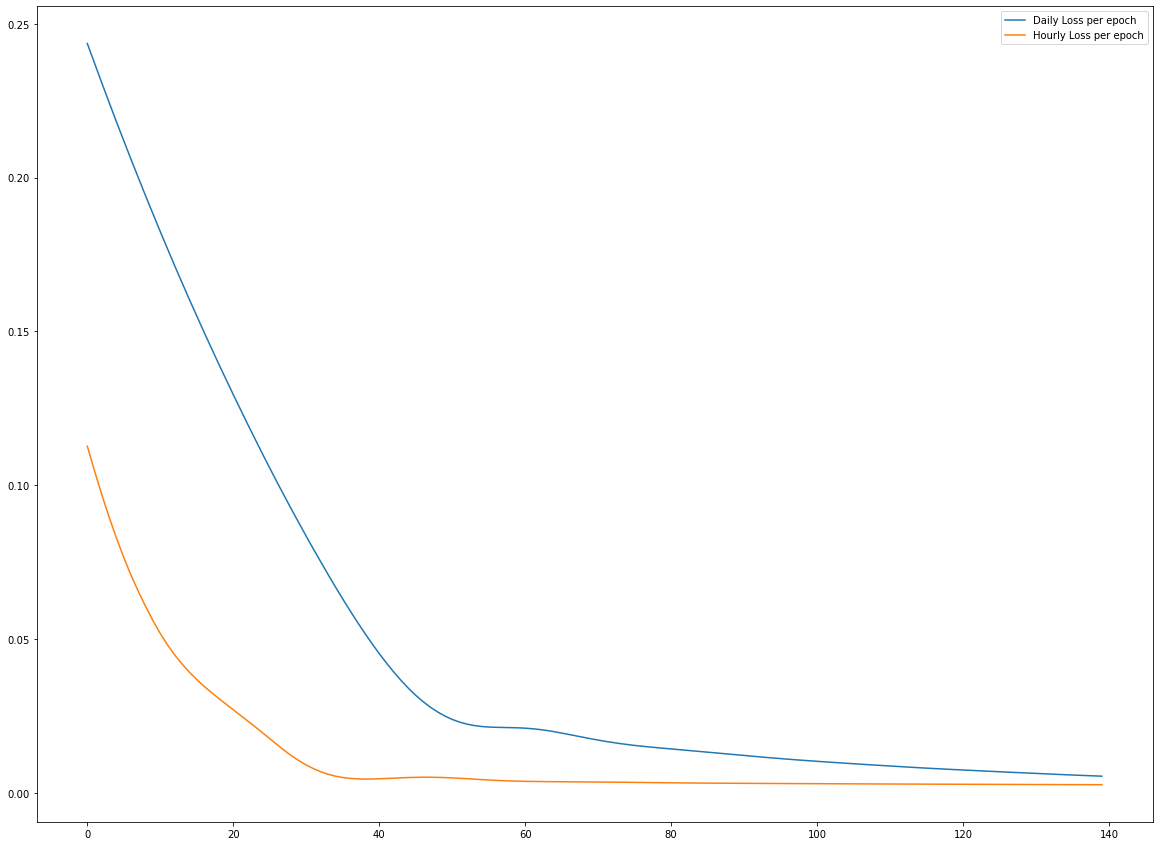

In [24]:
#Plot LossData
def plotLoss():
    plt.figure(figsize=(20, 15))
    plt.plot(lossData_daily, label="Daily Loss per epoch")
    plt.plot(lossData_hourly, label="Hourly Loss per epoch")
    plt.legend()
    plt.show()

plotLoss()

Loss_hourly: 0.00101, Loss_daily 0.00297 


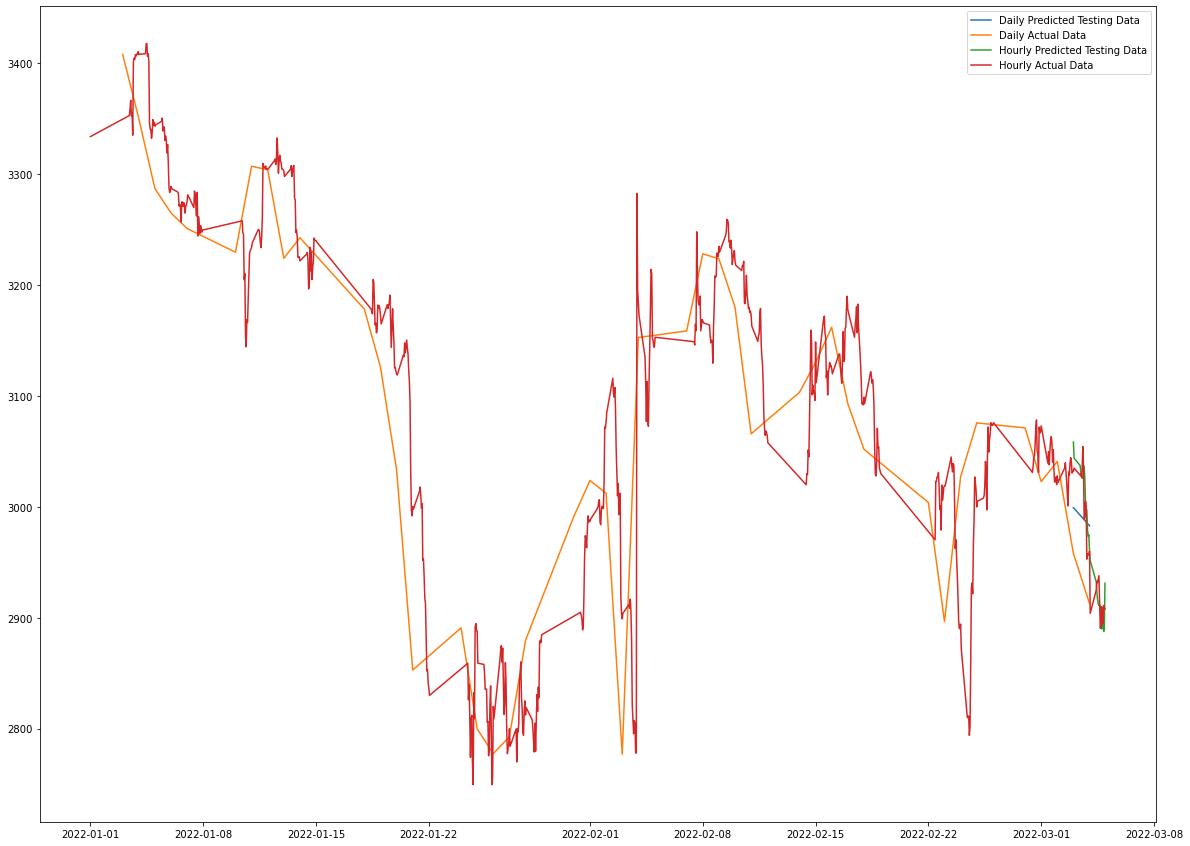

In [25]:
#Testing
def test(plotting: boolean):
    model.eval()
    optimizer.zero_grad()
    output_hourly, output_daily = model(X_hourly_test_tensors, X_daily_test_tensors)
    loss_hourly = criterion_hourly(output_hourly, y_hourly_test_tensors)
    loss_daily = criterion_daily(output_daily, y_daily_test_tensors)
    print("Loss_hourly: %1.5f, Loss_daily %1.5f " % (loss_hourly.item(), loss_daily.item()))

    output_daily = mm_daily.inverse_transform(output_daily.data.numpy()).flatten().tolist()
    a = [np.nan] * (len(data_daily)-len(output_daily))
    output_daily = a + output_daily
    data_daily["Predicted Testing Data"] = output_daily


    output_hourly = mm_hourly.inverse_transform(output_hourly.data.numpy()).flatten().tolist()
    b = [np.nan] * (len(data_hourly)- len(output_hourly))
    output_hourly = b + output_hourly
    data_hourly["Predicted Testing Data"] = output_hourly

    if plotting:
        plt.figure(figsize=(20, 15))
        plt.plot(data_daily["Predicted Testing Data"], label="Daily Predicted Testing Data")
        plt.plot(data_daily["CLOSE"], label="Daily Actual Data")
        plt.plot(data_hourly["Predicted Testing Data"], label="Hourly Predicted Testing Data")
        plt.plot(data_hourly["CLOSE"], label="Hourly Actual Data")
        plt.legend()
        plt.show()
    
test(True)